In [124]:
#!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# 01-NBME-Data-Exploration

Background: https://www.kaggle.com/competitions/nbme-score-clinical-patient-notes

Objectives: 
1. identify if clinical concepts as specified in 'features' are captured for each clinical case
2. extract the texts (start_char, end_char) in clinical notes 'patient_notes' that correspond to the clinical concepts

In [135]:
# import libraries

import numpy as np
import pandas as pd
import os
from ast import literal_eval
import plotly.express as px
import matplotlib.pyplot as plt
import spacy

1. Data Overview

In [2]:
df_notes = pd.read_csv('patient_notes.csv')
df_feature = pd.read_csv('features.csv')
df_train = pd.read_csv('train.csv')

In [3]:
df_notes.columns

Index(['pn_num', 'case_num', 'pn_history'], dtype='object')

In [4]:
print('unique pn_num:', df_notes['pn_num'].nunique())
print('unique case_num:', df_notes['case_num'].nunique())
print('unique pn_history:', df_notes['pn_history'].nunique())

unique pn_num: 42146
unique case_num: 10
unique pn_history: 42146


In [5]:
print('unique records per case:')
df_notes.groupby('case_num')['pn_num'].nunique()

unique records per case:


case_num
0    2268
1     808
2    1958
3    9753
4    5405
5    6909
6    1597
7    4101
8    4196
9    5151
Name: pn_num, dtype: int64

In [6]:
print('#feature_num: ', df_feature.feature_num.nunique())
print('#feature_txt: ', df_feature.feature_text.nunique()) 

#feature_num:  143
#feature_txt:  131


In [7]:
for col in df_feature.columns:
    print('---------------------------------------','\n')
    print(col, ': ')
    print(df_feature[col].value_counts())
    

--------------------------------------- 

feature_num : 
0      1
611    1
605    1
606    1
607    1
      ..
305    1
306    1
307    1
308    1
916    1
Name: feature_num, Length: 143, dtype: int64
--------------------------------------- 

case_num : 
5    18
8    18
2    17
9    17
3    16
0    13
1    13
6    12
4    10
7     9
Name: case_num, dtype: int64
--------------------------------------- 

feature_text : 
Female                                   7
Male                                     3
20-year                                  2
Nausea                                   2
35-year                                  2
                                        ..
44-year                                  1
Sleep-disturbance-OR-Early-awakenings    1
Heavy-sweating                           1
Onset-3-years-ago                        1
Subjective-fever                         1
Name: feature_text, Length: 131, dtype: int64


In [8]:
# a few feature entities (feature_text) are shared by multiple cases and take on a unique feature_num
# an example below:
df_feature[df_feature['feature_text']=='Female']

,feature_num,case_num,feature_text
25,112,1,Female
34,208,2,Female
66,407,4,Female
70,501,5,Female
99,700,7,Female
110,802,8,Female
139,913,9,Female


In [9]:
print('# of unique feature entities to be mapped out for each case: ')
df_feature.groupby(['case_num'])['feature_text'].count()

# of unique feature entities to be mapped out for each case: 


case_num
0    13
1    13
2    17
3    16
4    10
5    18
6    12
7     9
8    18
9    17
Name: feature_text, dtype: int64

2. Train data: a subset of clinical notes are provided as train data where annotation and location are given for each feature entities

In [10]:
df_train.shape

(14300, 6)

In [11]:
df_train.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [12]:
df_train_w_notes = pd.merge(df_train, df_notes, how='left', left_on = ['case_num','pn_num'], right_on=['case_num','pn_num'])
df_train_w_notes.shape

(14300, 7)

In [13]:
data = pd.merge(df_train_w_notes, df_feature, how='left', left_on = ['case_num','feature_num'], right_on=['case_num','feature_num'])

data.shape

(14300, 8)

In [14]:
data.head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-thyroid-disorder
2,00016_002,0,16,2,['chest pressure'],['203 217'],HPI: 17yo M presents with palpitations. Patien...,Chest-pressure
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",HPI: 17yo M presents with palpitations. Patien...,Intermittent-symptoms
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],HPI: 17yo M presents with palpitations. Patien...,Lightheaded


In [65]:
print('total # of cases in train: ', data['case_num'].nunique())

total # of cases in train:  10


In [16]:
print('# of notes for each case in train: ')
for i in data['case_num'].unique():
    print(i, ': ', data[data['case_num']==i]['pn_num'].nunique())

# of notes for each case in train: 
0 :  100
1 :  100
2 :  100
3 :  100
4 :  100
5 :  100
6 :  100
7 :  100
8 :  100
9 :  100


In [17]:
print('Feature Entities in Training Data:','\n')
print('#feature_num: ', data.feature_num.nunique())
print('#feature_txt: ', data.feature_text.nunique())

Feature Entities in Training Data: 

#feature_num:  143
#feature_txt:  131


In [18]:
# annotation and location for the mapped feature entities are stored as lists in the df
# each feature can have multiple sentence segments that are separated by comma
data['annot_count'] = data['annotation'].apply(lambda x: len(literal_eval(x)))
data['loc_count'] = data['location'].apply(lambda x: len(literal_eval(x)))

In [52]:
data.head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,annot_count,loc_count,is_annotated
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...,1,1,1
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-thyroid-disorder,1,1,1
2,00016_002,0,16,2,['chest pressure'],['203 217'],HPI: 17yo M presents with palpitations. Patien...,Chest-pressure,1,1,1
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",HPI: 17yo M presents with palpitations. Patien...,Intermittent-symptoms,2,2,1
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],HPI: 17yo M presents with palpitations. Patien...,Lightheaded,1,1,1


In [121]:
all_notes = []
all_notes_len = []
for notes in data['pn_history']:
    all_notes.append(notes)
    all_notes_len.append(len(notes))
print("Average length of Patient History - ",np.mean(all_notes_len))
fig = px.histogram(x = all_notes_len,  marginal="box",nbins = 100)
fig.update_xaxes(title = "Lenght of patient Notes")
fig.show()

Average length of Patient History -  816.7946153846154


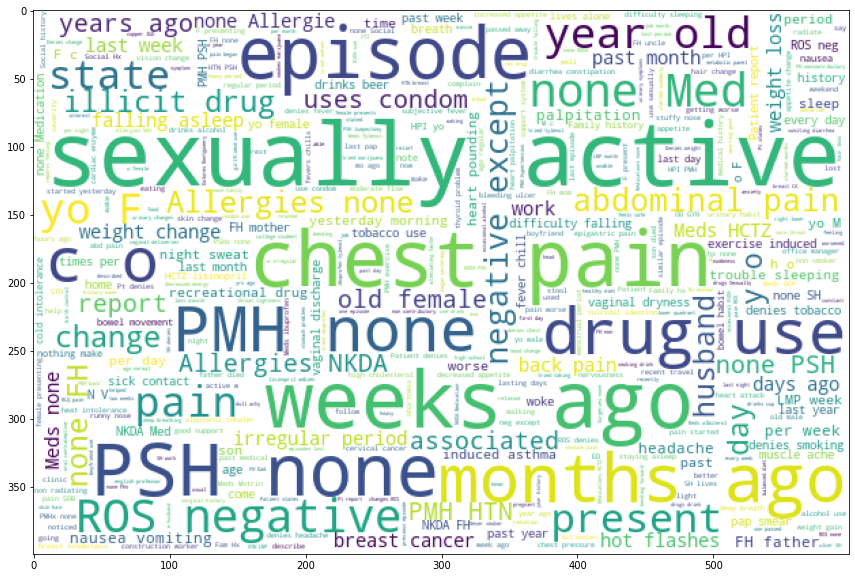

In [131]:
import wordcloud
wordcloud_notes = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, 
                                      max_font_size=100,
                                     max_words=5000,
                                      width=600,
                                      height=400,
                                      background_color='white').generate(" ".join(all_notes))
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(wordcloud_notes, interpolation='bilinear')
#ax.set_axis_off()
plt.imshow(wordcloud_notes)

Let's now take a look how feature texts are captured in the notes

In [98]:
df_feature['feature_len'] =df_feature['feature_text'].apply(lambda x: len(x))
feature_len = df_feature[['feature_num','feature_len']].set_index('feature_num')

In [102]:
feature_captured_count = data[data['annot_count']!=0].groupby(['feature_num'])['feature_num'].count()
feature_total_count = data.groupby(['feature_num'])['feature_num'].count()

Features = pd.DataFrame({'captured_count':feature_captured_count,
             'total_count':feature_total_count,
             'percent_captured': 100*feature_captured_count/feature_total_count})

Features in training data:


In [106]:
Features = pd.concat([Features, feature_len], axis=1)

In [117]:
fig = px.histogram(Features,
                   x = 'percent_captured',
                   marginal='box')
fig.update_layout(title ={
    'text':'Distribution of annotation success (%) across all feature texts',
'y':0.9,
'x':0.5},
                  template ='plotly_white')
fig.show()

In [118]:
fig = px.histogram(Features,
                   x = 'feature_len',
                   marginal='box')
fig.update_layout(title ={
    'text':'Distribution of feature texts length',
'y':0.9,
'x':0.5},
                  template ='plotly_white')
fig.show()

In [119]:
fig = px.scatter(Features,
                x='feature_len',
                y='percent_captured')
fig.show()

In [19]:
print('Features captured per case in training data:')
average_feature_captured = data[data['annot_count']!=0].groupby(['case_num','pn_num'])['feature_num'].nunique().groupby(['case_num']).mean()
total_feature_count = df_feature.groupby(['case_num'])['feature_text'].count()

pd.DataFrame({'Avg_feature_captured':average_feature_captured,
             'total_feature_count_per_case':total_feature_count,
             'Avg_percent_captured': 100*average_feature_captured/total_feature_count})


Features captured per case in training data:


,Avg_feature_captured,total_feature_count_per_case,Avg_percent_captured
case_num,,,
0,9.98,13,76.769231
1,9.42,13,72.461538
2,9.98,17,58.705882
3,11.98,16,74.875000
4,7.46,10,74.600000
5,11.74,18,65.222222
6,9.71,12,80.916667
7,6.92,9,76.888889
8,11.90,18,66.111111


In [20]:
data[['annot_count', 'loc_count']].value_counts()

annot_count  loc_count
1            1            8181
0            0            4399
2            2            1296
3            3             287
4            4              99
5            5              27
6            6               9
7            7               1
8            8               1
dtype: int64

In [21]:
data[data['annot_count']!=data['loc_count']]

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,annot_count,loc_count


In [22]:
data[data['annot_count']==0].head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,annot_count,loc_count
5,00016_005,0,16,5,[],[],HPI: 17yo M presents with palpitations. Patien...,No-hair-changes-OR-no-nail-changes-OR-no-tempe...,0,0
7,00016_007,0,16,7,[],[],HPI: 17yo M presents with palpitations. Patien...,Shortness-of-breath,0,0
8,00016_008,0,16,8,[],[],HPI: 17yo M presents with palpitations. Patien...,Caffeine-use,0,0
13,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0
17,00041_004,0,41,4,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Lightheaded,0,0


In [83]:
annot_count = data['annot_count'].value_counts()
fig = px.bar(data_frame = annot_count,
            x = annot_count.index,
            y = 'annot_count',
            color = 'annot_count',
            color_continuous_scale = 'Emrld'
            )
fig.update_layout(title ={
    'text':'Distribution of annotation count per row',
'y':0.9,
'x':0.5},
                  template ='plotly_white')
fig.show()

In [23]:
data['is_annotated']=data['annot_count'].apply(lambda x: 0 if x==0 else 1)

In [26]:
feature_summary_train = data.groupby(['feature_num'])['is_annotated'].agg('sum')

In [27]:
feature_summary_train.describe()

count    143.000000
mean      69.237762
std       26.783419
min        1.000000
25%       53.000000
50%       76.000000
75%       91.000000
max      100.000000
Name: is_annotated, dtype: float64

In [28]:
feature_summary_train[feature_summary_train<=10]

feature_num
209    1
807    1
809    7
911    2
Name: is_annotated, dtype: int64

In [29]:
data[data['feature_num'].isin([209,807,809,911])]['case_num'].unique()

array([2, 8, 9], dtype=int64)

Features in train:
* 50% of the features are annotated in 80% of the notes
* 25% of the features are annotated in 50% of the notes
* 4 features (209, 807, 809, 911) from 3 cases are found annotated in very few notes (<10%)

In [30]:
annotation_abnormaly = data[data['location'].str.contains(';')]

In [31]:
print('# of rows with ; in annotation text: ', annotation_abnormaly.shape[0])
print('cases with this issue: ', annotation_abnormaly['case_num'].unique())
print('cases with this issue: ', annotation_abnormaly['pn_num'].nunique())

# of rows with ; in annotation text:  1650
cases with this issue:  [0 1 2 3 4 5 6 7 8 9]
cases with this issue:  737


In [33]:
annotation_abnormaly[(annotation_abnormaly['case_num']==5)].head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,annot_count,loc_count,is_annotated
6906,50072_506,5,50072,506,['No CP'],['426 428;437 439'],Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,No-chest-pain,1,1,1
6907,50072_507,5,50072,507,['No drug use'],['721 723;744 752'],Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,No-illicit-drug-use,1,1,1
6914,50072_514,5,50072,514,"['numbness of fingertips', 'numbness of hands']","['357 379', '357 368;388 393']",Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,Episode-of-hand-numbness-OR-Episode-of-finger-...,2,2,1
6922,50199_504,5,50199,504,"['palpitations', 'heart racing']","['65 77', '107 112;129 135']",Ms. Whelan is a 26y/o F presenting to f/u from...,Episodes-of-heart-racing,2,2,1
6943,50375_507,5,50375,507,['Denies durg use'],['773 779;798 806'],Edie Whelan is a 26 year old female who presen...,No-illicit-drug-use,1,1,1


In [33]:
pn_50072 = annotation_abnormaly[(annotation_abnormaly['case_num']==5) & (annotation_abnormaly['pn_num']==50072)].iloc[0].pn_history
pn_50072

'Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitations that have been increasing in freq in the past 2 weeks. She was seen 2 weeks ago for similar symptoms with a w/u WNL. \r\n-The events last 12-30 min, are not assoc with anything particular, no alleviating or aggrevating factors. \r\n-She has assoc SOB, hot and then cold and clamy skin\r\n-Recently had numbness of fingertips on both hands during palpitation event \r\nROS: No dyspne, CP, skin, hair or wt changes. \r\nPMH: none\r\nPSH: None \r\nMeds: none \r\nAllergies: NKD\r\nFH: non contributory \r\nSH: 2 months unemployed, recently purchased a condo but is optomistic about her financial and occupational situation. Lives alone, sexual active with one partner, uses condoms. No alcohol, tobacco or drug use.'

In [34]:
list(pn_50072)[426:439]

['N', 'o', ' ', 'd', 'y', 's', 'p', 'n', 'e', ',', ' ', 'C', 'P']

In [47]:

def loc_list_to_ints(loc_list):
  # takes a list of location strings as input and converts it to a list of tuples of integers 
  # representing the start and end positions of each location in the original input text
    to_return = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return

In [157]:
df_50072 = data[(data['pn_num']==50072) & (data['annot_count']==1)]
location = df_50072['location']
location = [literal_eval(x) for x in location]
annotation = df_50072['annotation']

In [149]:
[loc_list_to_ints(x) for x in location]

[[(22, 23)],
 [(298, 307)],
 [(120, 176)],
 [(426, 428), (437, 439)],
 [(721, 723), (744, 752)],
 [(76, 114)],
 [(192, 206)],
 [(331, 336)],
 [(548, 595)],
 [(16, 21)]]

In [159]:
start_pos = []
end_pos = []
for x in location:
    x = loc_list_to_ints(x)
    for i in x: 
        start_pos.append(i[0])
        end_pos.append(i[1])
        
ents = []
for i in range(len(start_pos)):
    ents.append({
        'start': int(start_pos[i]),
        'end': int(end_pos[i]),
        'label': "Annotation"
    })
    
doc = {
    'text' : pn_50072,
    "ents" : ents
}
colors = {"Annotation" :"linear-gradient(90deg, #aa9cfc, #fc9ce7)" } 
options = {"colors": colors}
spacy.displacy.render(doc, style="ent", options = options , manual=True)

In [37]:
annotation_abnormaly.head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,annot_count,loc_count,is_annotated
48,00082_009,0,82,9,"['heart pounding', 'heart racing', 'heart poun...","['85 99', '126 138', '126 131;143 151']",17 yo M w/ no cardiac or arrhythmia PMH presen...,heart-pounding-OR-heart-racing,3,3,1
91,00211_000,0,211,0,['Father MI'],['682 688;695 697'],HPI: Patient is a 17 yo m with a c/o of palpit...,Family-history-of-MI-OR-Family-history-of-myoc...,1,1,1
96,00211_005,0,211,5,['Denies sweating'],['462 468;473 481'],HPI: Patient is a 17 yo m with a c/o of palpit...,No-hair-changes-OR-no-nail-changes-OR-no-tempe...,1,1,1
100,00211_009,0,211,9,"['palpitations', 'Palpitations', 'palpitations...","['40 52', '55 67', '104 116', '161 178', '161 ...",HPI: Patient is a 17 yo m with a c/o of palpit...,heart-pounding-OR-heart-racing,5,5,1
125,00225_008,0,225,8,"['drinks coffee', 'drinks energy drinks']","['461 467;483 489', '461 467;506 519']",17 y/o previously healthy male here with heart...,Caffeine-use,2,2,1


In [50]:
literal_eval(annotation_abnormaly["location"].iloc[0])

['85 99', '126 138', '126 131;143 151']

In [51]:
#annotation_abnormaly["location_list"] = [literal_eval(x) for x in annotation_abnormaly["location"]]
loc_list_to_ints(literal_eval(annotation_abnormaly["location"].iloc[0]))

[(85, 99), (126, 138), (126, 131), (143, 151)]

Annotations: 
1. There are 4399 records where no annotated texts are found
2. Feature_text can be annotated by both single text segment as well as multiple separate text segments. 
3. Number of annotations for each matches the number of location (start, end)
4. If there are multiple text segments, each location pair is separated by ';'
5. Case_num 2 and 9 have the lowest numbers of features captured (below 60%)

In [91]:
data.to_csv('data.csv', index=False)